# Biotech Trend Intelligence

## Introduction

### Problem

Biotechnology moves quickly, and meaningful developments are scattered across dozens of news sources, journals, and industry feeds. Manually tracking these updates is time-consuming, inconsistent, and prone to missing important signals. Raw article text is noisy and difficult to compare, making it hard to identify which topics are emerging, which are declining, and where industry attention is shifting. There is no simple, automated way to transform daily biotech news into structured, trend-level insights.

### Solution/Objective

This project implements an automated RSS-driven pipeline that collects biotech articles, summarizes them using an LLM, and extracts key concepts for trend analysis. A Trend Agent clusters related topics, measures their frequency and momentum, and highlights emerging or unusual patterns across the dataset. The final output is a structured, data-driven trend report that makes it easy to monitor the biotech landscape, spot early signals, and stay informed without manual curation.

## Import Libraries

In [ ]:
!pip install feedparser
!pip install google-genai


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import feedparser
import datetime
import json
from pathlib import Path
import pandas as pd
from bs4 import BeautifulSoup
from google import genai
import time
import re

## Fetch RSS Articles

In [9]:
import feedparser
import datetime
import json
from pathlib import Path

class RSSFetcher:
    def __init__(self, config_path="config/rss_feeds.json", storage_path="../data/rss_raw.json"):
        self.config_path = Path(config_path)
        self.storage_path = Path(storage_path)
        self.storage_path.parent.mkdir(parents=True, exist_ok=True)

        # Load feeds from config file
        with open(self.config_path, "r") as f:
            self.rss_urls = json.load(f)["feeds"]

    def _infer_source(self, url: str) -> str:
        """Infer source name from URL."""
        if "fiercebiotech.com/rss/biotech" in url or "fiercebiotech.com/rss/xml" in url:
            return "FierceBiotech"
        elif "labiotech.eu" in url:
            return "Labiotech.eu"
        elif "GenEngNews" in url or "genengnews.com" in url:
            return "GEN (Genetic Engineering & Biotech News)"
        elif "sciencedaily.com" in url and "genetics_gene_therapy" in url:
            return "ScienceDaily – Gene Therapy"
        elif "bioworld.com/rss/topic/10" in url:
            return "BioWorld Omics / Genomics"
        elif "genomeweb.com/rss-feeds" in url:
            return "GenomeWeb"
        elif "biopharmadive.com/feeds/news" in url:
            return "BioPharma Dive"
        elif "endpts.com/feed" in url:
            return "Endpoints News"
        elif "biologynews.net/feeds/biotechnology.xml" in url:
            return "Biology News Net – Biotechnology"
        elif "isaaa.org/rss/cropbiotechupdate" in url:
            return "ISAAA – Crop Biotech Update"
        elif "fda.gov" in url and "MedWatch" in url:
            return "FDA MedWatch"
        elif "bayer.com/rss/CORPORATE_NEWS.xml" in url:
            return "Bayer Corporate News"
        elif "pharma-iq.com/rss-feeds/articles" in url:
            return "Pharma IQ"
        elif "the-dna-universe.com/feed" in url:
            return "The DNA Universe"
        elif "frontlinegenomics.com/feed" in url:
            return "Front Line Genomics"
        elif "phasegenomics.com/feed" in url:
            return "Phase Genomics"
        elif "alitheagenomics.com/blog/rss.xml" in url:
            return "Alithea Genomics Blog"
        elif "genengnews.com/feed" in url:
            return "GEN (Genetic Engineering & Biotech News)"
        elif "biospace.com/rss/topstories.xml" in url:
            return "BioSpace Top Stories"
        elif "nature.com/subjects/genetics.rss" in url:
            return "Nature – Genetics"
        else:
            return "Unknown"

    def fetch(self):
        """Fetch articles from all RSS URLs."""
        all_articles = []

        for url in self.rss_urls:
            feed = feedparser.parse(url)
            source = self._infer_source(url)

            print(f"Fetching from {source}: {url}")

            for entry in feed.entries:
                article = {
                    "title": entry.get("title"),
                    "summary": entry.get("summary", ""),
                    "link": entry.get("link"),
                    "published": entry.get("published") or entry.get("updated") or None,
                    "source": source,
                    "fetched_at": datetime.datetime.utcnow().isoformat()
                }
                all_articles.append(article)

        return all_articles

In [10]:
# Run Fetcher for generic RSS (including PubMed)
#from src.fetcher import RSSFetcher

# This will load feeds from config/rss_feeds.json by default
fetcher = RSSFetcher()

articles = fetcher.fetch()

# Convert to df
articles = pd.DataFrame(articles)

print(f"Fetched {len(articles)} articles.")
display(articles[:3])  # show first 3

Fetching from FierceBiotech: https://www.fiercebiotech.com/rss/biotech/xml
Fetching from Labiotech.eu: https://www.labiotech.eu/feed/
Fetching from GEN (Genetic Engineering & Biotech News): https://feeds.feedburner.com/GenEngNews
Fetching from ScienceDaily – Gene Therapy: https://rss.sciencedaily.com/genetics_gene_therapy.xml
Fetching from BioWorld Omics / Genomics: https://www.bioworld.com/rss/topic/10
Fetching from GenomeWeb: https://www.genomeweb.com/rss-feeds
Fetching from BioPharma Dive: https://www.biopharmadive.com/feeds/news
Fetching from Endpoints News: https://endpts.com/feed
Fetching from Biology News Net – Biotechnology: http://www.biologynews.net/feeds/biotechnology.xml
Fetching from ISAAA – Crop Biotech Update: https://www.isaaa.org/rss/cropbiotechupdate/
Fetching from FDA MedWatch: http://www.fda.gov/AboutFDA/ContactFDA/StayInformed/RSSFeeds/MedWatch/rss.xml
Fetching from Bayer Corporate News: https://www.bayer.com/rss/CORPORATE_NEWS.xml
Fetching from Pharma IQ: https://

,title,summary,link,published,source,fetched_at
0,"<a href=""https://www.fiercebiotech.com/biotech...",A drug safety group has delivered a positive a...,https://www.fiercebiotech.com/biotech/sarepta-...,"Nov 24, 2025 3:18pm",FierceBiotech,2025-11-25T02:08:41.503945
1,"<a href=""https://www.fiercebiotech.com/biotech...",Swedish biotech Sprint Bioscience is selling o...,https://www.fiercebiotech.com/biotech/gilead-h...,"Nov 24, 2025 12:04pm",FierceBiotech,2025-11-25T02:08:41.503945
2,"<a href=""https://www.fiercebiotech.com/biotech...",VC Versant Ventures is unveiling Dayra Therape...,https://www.fiercebiotech.com/biotech/versants...,"Nov 24, 2025 10:29am",FierceBiotech,2025-11-25T02:08:41.503945


In [11]:
# Clean up articles and extract titles and summaries
from bs4 import BeautifulSoup

# Convert summaries to plain text
articles['summary_text'] = articles['summary'].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())

# Print just the top 5 titles and converted summaries
for title in articles['title'].head(5):
    print("Title:", title)
print()
for summary_text in articles['summary_text'].head(5):
    print("Summary text:", summary_text)

Title: <a href="https://www.fiercebiotech.com/biotech/sarepta-shares-positive-safety-update-dm1-asset-arrowhead-hits-200m-milestone" hreflang="en">Sarepta shares positive safety update on DM1 asset as Arrowhead snares $200M milestone</a>
Title: <a href="https://www.fiercebiotech.com/biotech/gilead-hatches-400m-biobucks-deal-swedish-biotechs-trex1-cancer-program" hreflang="en">Gilead hatches $400M biobucks deal for Swedish biotech’s TREX1 cancer program</a>
Title: <a href="https://www.fiercebiotech.com/biotech/versants-dayra-dawns-50m-biogen-pact-oral-macrocyclic-peptide-mission" hreflang="en">Versant's Dayra dawns with $50M Biogen pact, oral macrocyclic peptide mission</a>
Title: <a href="https://www.fiercebiotech.com/biotech/jjs-5b-alzheimers-hope-fades-anti-tau-antibody-posdinemab-flops-phase-2" hreflang="en">J&amp;J's $5B Alzheimer's hope fades as anti-tau antibody posdinemab flops in phase 2</a>
Title: <a href="https://www.fiercebiotech.com/biotech/bayers-asundexian-cuts-stroke-ris

## Summarize Articles (Agent)

In [13]:
from google import genai
import time
import os
import math

# -----------------------------
# Setup client
# -----------------------------
api_key_env = os.getenv("GOOGLE_API_KEY")  # from local environment variable
client = genai.Client(api_key=api_key_env)

MODEL_NAME = "gemini-2.5-flash"

# -----------------------------
# Free-tier batching parameters
# -----------------------------
FREE_TIER_LIMIT = 10          # max requests per minute
batch_size = 5                # number of articles per batch (≤ FREE_TIER_LIMIT)
sleep_time = 35               # seconds to sleep between batches

# -----------------------------
# Summarization function
# -----------------------------
def summarize_article(title: str, summary: str) -> dict:
    prompt = f"""
    You are an AI biotech assistant. Summarize this article in 3 bullet points.
    Extract: 
    1. Main finding
    2. Key biological targets (genes, proteins, pathways)
    3. Application area (diagnostics, therapeutics, biotech tools, etc.)

    Title: {title}
    Summary: {summary}
    """

    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=prompt
    )

    return {
        "title": title,
        "raw_summary": summary,
        "ai_summary": response.text
    }

# -----------------------------
# Generate summaries in batches
# -----------------------------
summaries = []

num_batches = math.ceil(len(articles) / batch_size)

for batch_idx in range(num_batches):
    start = batch_idx * batch_size
    end = start + batch_size
    batch = articles.iloc[start:end]

    for _, row in batch.iterrows():
        summaries.append(
            summarize_article(row["title"], row["summary_text"])["ai_summary"]
        )

    # Sleep after each batch to respect free-tier quota
    if batch_idx + 1 < num_batches:
        print(f"Batch {batch_idx+1}/{num_batches} done, sleeping {sleep_time}s...")
        time.sleep(sleep_time)

# Save summaries back to DataFrame
articles["ai_summary"] = summaries

# -----------------------------
# Check results
# -----------------------------
print(articles[["title", "ai_summary"]].head())

Batch 1/43 done, sleeping 35s...
Batch 2/43 done, sleeping 35s...
Batch 3/43 done, sleeping 35s...
Batch 4/43 done, sleeping 35s...
Batch 5/43 done, sleeping 35s...
Batch 6/43 done, sleeping 35s...
Batch 7/43 done, sleeping 35s...
Batch 8/43 done, sleeping 35s...
Batch 9/43 done, sleeping 35s...
Batch 10/43 done, sleeping 35s...
Batch 11/43 done, sleeping 35s...
Batch 12/43 done, sleeping 35s...
Batch 13/43 done, sleeping 35s...
Batch 14/43 done, sleeping 35s...
Batch 15/43 done, sleeping 35s...
Batch 16/43 done, sleeping 35s...
Batch 17/43 done, sleeping 35s...
Batch 18/43 done, sleeping 35s...
Batch 19/43 done, sleeping 35s...
Batch 20/43 done, sleeping 35s...
Batch 21/43 done, sleeping 35s...
Batch 22/43 done, sleeping 35s...
Batch 23/43 done, sleeping 35s...
Batch 24/43 done, sleeping 35s...
Batch 25/43 done, sleeping 35s...
Batch 26/43 done, sleeping 35s...
Batch 27/43 done, sleeping 35s...
Batch 28/43 done, sleeping 35s...
Batch 29/43 done, sleeping 35s...
Batch 30/43 done, sleep

In [14]:
# Save summarized articles to JSON

from pathlib import Path
import json

# Convert entire DataFrame to list of dicts
articles_list = articles.to_dict(orient="records")

output_path = Path("data/rss_summarized.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(articles_list, f, indent=2, ensure_ascii=False)

print(f"Saved {len(articles_list)} articles to {output_path}")

# Add section to append new articles without duplicates if needed - probably not since we already have 213 static articles saved

Saved 212 articles to data\rss_summarized.json


## AI Summary Embeddings

We have to skip this step, free Gemini tier doesn't include it in the API.

In [ ]:
"""
from google import genai
from google.genai import types
import os, json, time

client = genai.Client(api_key=os.getenv("GOOGLE_API_KEY"))

# Load articles
with open("data/rss_summarized.json", "r", encoding="utf-8") as f:
    articles = json.load(f)

texts = [article["ai_summary"] for article in articles]

EMBEDDING_MODEL = "gemini-embedding-001"
batch_size = 20
sleep_between = 1
max_retries = 3

embeddings = []

def embed_batch(batch_texts):
    for attempt in range(max_retries):
        try:
            resp = client.models.embed_content(
                model=EMBEDDING_MODEL,
                contents=batch_texts,
                config=types.EmbedContentConfig(output_dimensionality=768)
            )
            # Extract embeddings correctly
            return [e.values for e in resp.embeddings]
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {e}")
            time.sleep(2)
    raise RuntimeError("Failed to embed after retries")

# Process in batches
for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    batch_emb = embed_batch(batch)
    embeddings.extend(batch_emb)
    print(f"Embedded batch {i // batch_size + 1}")
    time.sleep(sleep_between)

# Attach embeddings to articles
for idx, article in enumerate(articles):
    article["embedding"] = embeddings[idx]

# Save to JSON
with open("data/articles_with_embeddings.json", "w", encoding="utf-8") as f:
    json.dump(articles, f, indent=2, ensure_ascii=False)

print("Embeddings generation complete.")
"""

Embedded batch 1
Embedded batch 2
Attempt 1 failed: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/embed_content_free_tier_requests, limit: 0', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/embed_content_free_tier_requests', 'quotaId': 'EmbedContentRequestsPerMinutePerUserPerProjectPerModel-FreeTier'}]}]}}
Attempt 2 failed: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, '

RuntimeError: Failed to embed after retries

## Trend Analysis (Agent)

In [2]:
from google import genai
from google.genai import types
import os, json, time

# -----------------------------
# CONFIG
# -----------------------------
API_KEY = os.getenv("GOOGLE_API_KEY")
MODEL_NAME = "gemini-2.5-flash"
BATCH_SIZE = 1
SLEEP_BETWEEN = 10
MAX_OUTPUT_TOKENS = 4000
TEMPERATURE = 0.25

INPUT_FILE = "data/rss_summarized.json"
OUTPUT_FILE = "data/trending_topics.json"

# -----------------------------
# Initialize client
# -----------------------------
client = genai.Client(api_key=API_KEY)

# -----------------------------
# Load articles
# -----------------------------
with open(INPUT_FILE, "r", encoding="utf-8") as f:
    articles = json.load(f)

all_trending_results = []

# -----------------------------
# Prompt builder
# -----------------------------
def make_prompt(batch_articles, summary_max_chars=250):
    minimal_batch = [
        {"title": a["title"], "ai_summary": a["ai_summary"][:summary_max_chars]}
        for a in batch_articles
    ]
    return f"""
You are an AI biotech research analyst. 
You have {len(minimal_batch)} articles in JSON format:

{json.dumps(minimal_batch)}

Your task:
1. Detect emerging trends in biotech based on the ai_summary text.
2. Cluster articles into thematic groups or topics.
3. Identify top trending topics by novelty, frequency, or growth.
4. Extract key terms, proteins, methods, or concepts associated with each trend.
5. Provide a trend score (1-10) for each topic/cluster.
6. Return results in JSON with:
   - "topic": name or representative keywords
   - "trend_score": numeric score
   - "articles": list of titles under that topic
   - "key_terms": top 5 keywords or concepts
   - "summary": 1-2 sentence overview of the trend

Please output strictly JSON. Do NOT include any commentary.
Return an array JSON list even if only one topic is detected.
"""

# -----------------------------
# Batch processing
# -----------------------------
for i in range(0, len(articles), BATCH_SIZE):
    batch_articles = articles[i:i+BATCH_SIZE]
    prompt = make_prompt(batch_articles)

    try:
        response = client.models.generate_content(
            model=MODEL_NAME,
            contents=prompt,
            config=types.GenerateContentConfig(
                temperature=TEMPERATURE,
                max_output_tokens=MAX_OUTPUT_TOKENS
            )
        )

        if not response.text:
            print(f"Warning: batch {i//BATCH_SIZE + 1} returned empty response")
            continue

        # Clean Markdown fences
        response_text = response.text.strip()
        if response_text.startswith("```"):
            response_text = response_text.strip("`").strip()
            # Also handle "```json\n ... \n```"
            response_text = response_text.replace("json", "", 1).strip()

        try:
            batch_results = json.loads(response_text)
            all_trending_results.extend(batch_results)
        except json.JSONDecodeError as e:
            print(f"Warning: JSON parse error for batch {i//BATCH_SIZE + 1}: {e}")
            continue

    except Exception as e:
        print(f"Error processing batch {i//BATCH_SIZE + 1}: {e}")
        continue

    print(f"Processed batch {i//BATCH_SIZE + 1}/{(len(articles)-1)//BATCH_SIZE + 1}")
    time.sleep(SLEEP_BETWEEN)

# -----------------------------
# Save output
# -----------------------------
with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
    json.dump(all_trending_results, f, indent=2, ensure_ascii=False)

print(f"Trending topics JSON saved to '{OUTPUT_FILE}'.")

Processed batch 1/212
Processed batch 2/212
Processed batch 3/212
Processed batch 4/212
Processed batch 5/212
Processed batch 6/212
Processed batch 7/212
Processed batch 8/212
Processed batch 9/212
Processed batch 10/212
Processed batch 11/212
Processed batch 12/212
Processed batch 13/212
Processed batch 14/212
Processed batch 15/212
Processed batch 16/212
Processed batch 17/212
Processed batch 18/212
Processed batch 19/212
Processed batch 20/212
Processed batch 21/212
Processed batch 22/212
Processed batch 23/212
Processed batch 24/212
Processed batch 25/212
Processed batch 26/212
Processed batch 27/212
Processed batch 28/212
Processed batch 29/212
Processed batch 30/212
Processed batch 31/212
Processed batch 32/212
Processed batch 33/212
Processed batch 34/212
Processed batch 35/212
Processed batch 36/212
Processed batch 37/212
Processed batch 38/212
Processed batch 39/212
Processed batch 40/212
Processed batch 41/212
Processed batch 42/212
Processed batch 43/212
Processed batch 44/2

In [9]:
# Extract topics function
def extract_topics(text):
    if not isinstance(text, str):
        return {"scientific_terms": [], "companies": [], "concepts": [], "methods": []}

    text_lower = text.lower()

    # Scientific terms
    scientific_terms = re.findall(SCIENTIFIC_TERMS_REGEX, text_lower)

    # Companies: known + uppercase acronyms
    companies_found = [c for c in COMPANIES if c.lower() in text_lower]
    acronyms = re.findall(r'\b[A-Z]{2,}\b', text)
    companies_found += acronyms

    # Methods
    methods_found = [m for m in METHODS if m.lower() in text_lower]

    # Concepts
    concepts_found = [c for c in CONCEPTS if c.lower() in text_lower]

    return {
        "scientific_terms": list(set(scientific_terms)),
        "companies": list(set(companies_found)),
        "concepts": list(set(concepts_found)),
        "methods": list(set(methods_found))
    }

In [10]:
# Normalization
normalization_dict = {
    "single-cell": ["scRNA-seq", "single cell sequencing", "single-cell RNA seq", "single-cell"],
    "AI-biotech": ["AI", "machine learning", "deep learning"],
    "biotech IP/legal": ["Illumina lawsuit", "NGS patents"]
}

def normalize_topic(term: str):
    if not isinstance(term, str):
        return term
    for norm, variants in normalization_dict.items():
        if term.lower() == norm.lower() or term.lower() in [v.lower() for v in variants]:
            return norm
    return term

# Apply extraction + normalization
articles['topics_normalized'] = articles['title_clean'].apply(
    lambda s: {k: [normalize_topic(t) for t in v] for k, v in extract_topics(s).items()}
)

In [11]:
# Clustering
topic_clusters = {
    "single-cell": "Single-Cell Technologies",
    "AI-biotech": "AI in Biotech",
    "biotech IP/legal": "Biotech IP & Legal",
    "crispr": "Gene Editing",
    "sequencing": "Sequencing Technologies",
    "nanopore": "Sequencing Technologies",
    "rna-seq": "Sequencing Technologies",
    "illumina": "Major Biotech Companies",
    "10x genomics": "Major Biotech Companies",
    "pfizer": "Major Biotech Companies",
    "moderna": "Major Biotech Companies",
    "novartis": "Major Biotech Companies",
    "pacbio": "Sequencing Companies",
    "gilead": "Major Biotech Companies",
    "biogen": "Major Biotech Companies",
    "regeneron": "Major Biotech Companies",
    "fda": "Regulatory / Biotech Business",
    "review process": "Regulatory / Biotech Business",
    "staffing": "Regulatory / Biotech Business",
    "volatility": "Regulatory / Biotech Business"
}

def assign_cluster(term: str):
    if not isinstance(term, str):
        return None
    term_l = term.lower()
    for key, cluster in topic_clusters.items():
        if term_l == key.lower():
            return cluster
    return "Other"

In [12]:
# Build trend data
trend_data = []

for idx, row in articles.iterrows():
    topic_dict = row['topics_normalized']
    all_terms = []
    for cat, terms in topic_dict.items():
        all_terms.extend(terms)
    clusters = [assign_cluster(t) for t in all_terms]

    trend_data.append({
        "title": row['title_clean'],
        "source": row['source'],
        "published": row['published'],
        "topics": topic_dict,
        "clusters": clusters
    })

# Save trend data to JSON
output_path = Path("data/trend_topics.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(trend_data, f, indent=2, ensure_ascii=False)

print(f"Saved trend topics to {output_path}")


Saved trend topics to data\trend_topics.json


In [13]:
display(trend_data)  # show first 3 entries

[{'title': 'In letter to Makary, biotech CEOs push for FDA stability and say volatility threatens US innovation',
  'source': 'FierceBiotech',
  'published': 'Nov 21, 2025 4:16pm',
  'topics': {'scientific_terms': [],
   'companies': ['fda', 'FDA', 'US'],
   'concepts': ['biotech', 'volatility'],
   'methods': []},
  'clusters': ['Regulatory / Biotech Business',
   'Regulatory / Biotech Business',
   'Other',
   'Other',
   'Regulatory / Biotech Business']},
 {'title': " FDA says it's hiring more than 1,000 new staffers, launches new comms program for review process",
  'source': 'FierceBiotech',
  'published': 'Nov 21, 2025 11:20am',
  'topics': {'scientific_terms': [],
   'companies': ['fda', 'FDA'],
   'concepts': ['review process'],
   'methods': []},
  'clusters': ['Regulatory / Biotech Business',
   'Regulatory / Biotech Business',
   'Regulatory / Biotech Business']},
 {'title': 'Chutes & Ladders—Gilead abruptly parts ways with general counsel',
  'source': 'FierceBiotech',
  'p

In [14]:
import json
import pandas as pd

with open("data/trend_topics.json", "r", encoding="utf-8") as f:
    trend_data = json.load(f)

df = pd.DataFrame(trend_data)

In [15]:
from collections import Counter

# Flatten clusters lists
all_clusters = [cluster for clusters in df['clusters'] for cluster in clusters]
cluster_counts = Counter(all_clusters)

cluster_df = pd.DataFrame(cluster_counts.items(), columns=['Cluster', 'Count']).sort_values(by='Count', ascending=False)
print(cluster_df)

                         Cluster  Count
1                          Other     30
0  Regulatory / Biotech Business      8
2        Major Biotech Companies      7
3                  AI in Biotech      3


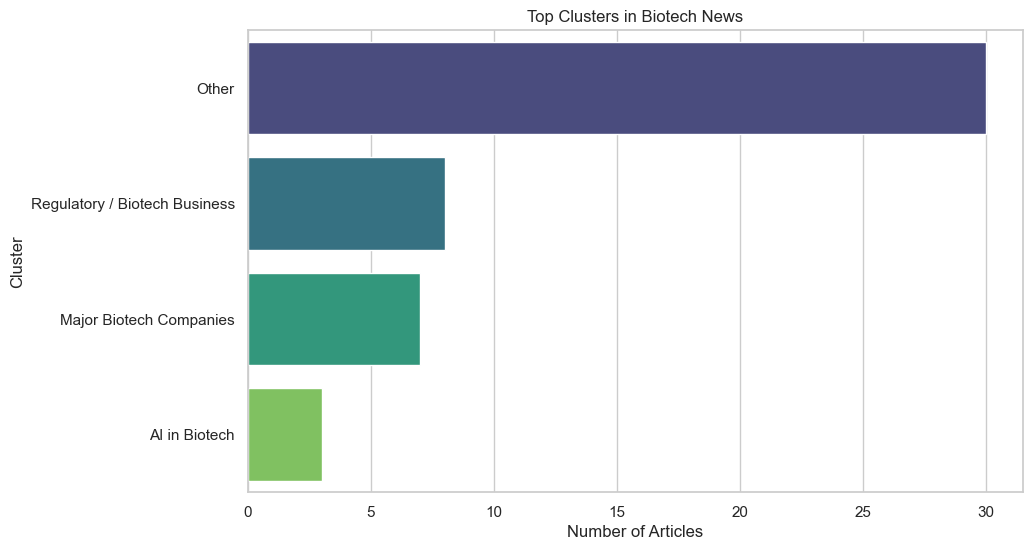

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.barplot(data=cluster_df, x='Count', y='Cluster', hue='Cluster', palette='viridis')
plt.title("Top Clusters in Biotech News")
plt.xlabel("Number of Articles")
plt.ylabel("Cluster")
plt.show()

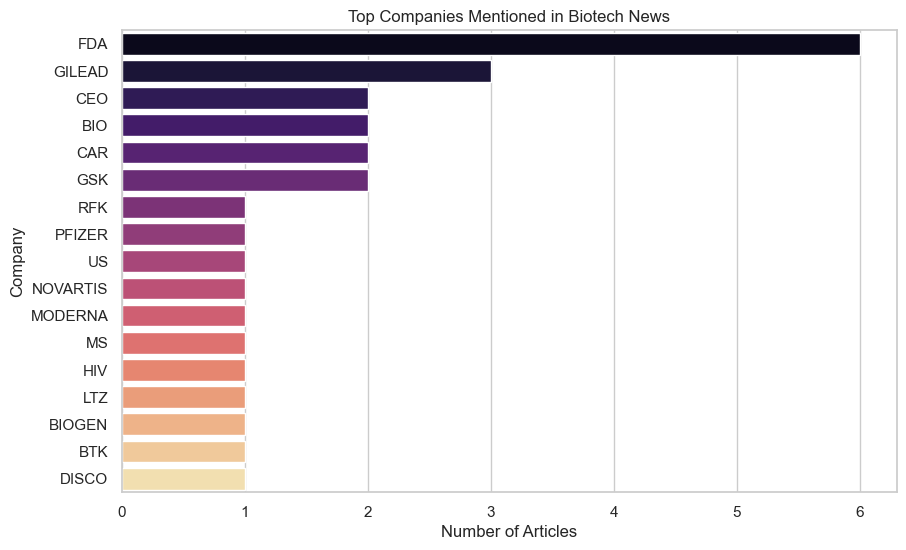

In [17]:
# Flatten companies
all_companies = [comp.upper() for topics in df['topics'] for comp in topics['companies']]
company_counts = Counter(all_companies)
company_df = pd.DataFrame(company_counts.items(), columns=['Company', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=company_df, x='Count', y='Company', hue='Company', palette='magma')
plt.title("Top Companies Mentioned in Biotech News")
plt.xlabel("Number of Articles")
plt.ylabel("Company")
plt.show()

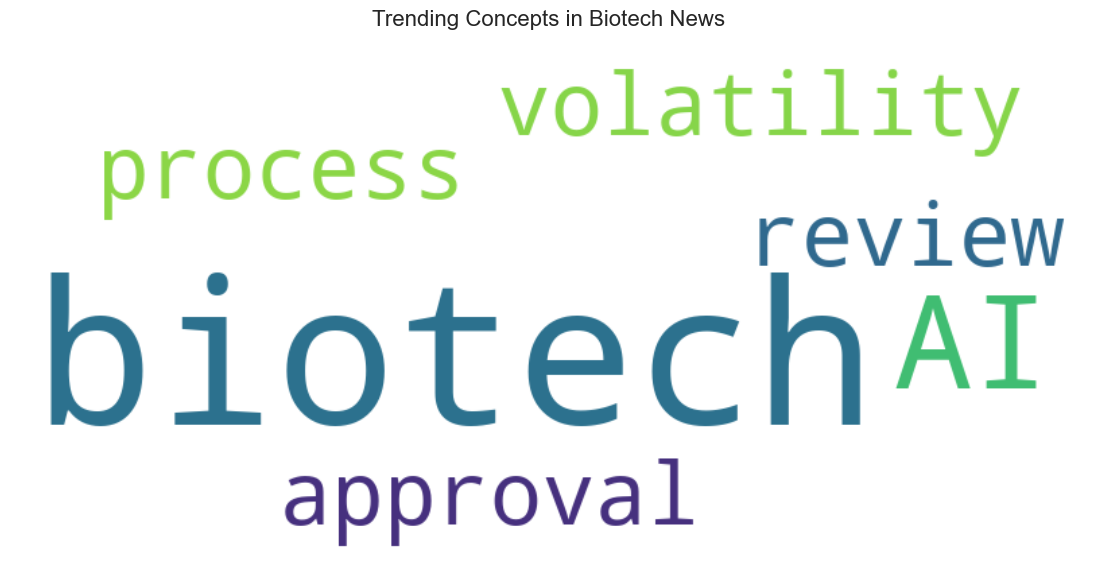

In [18]:
from wordcloud import WordCloud

all_concepts = [concept for topics in df['topics'] for concept in topics['concepts']]
concept_text = " ".join(all_concepts)

wc = WordCloud(width=800, height=400, background_color="white").generate(concept_text)

plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Trending Concepts in Biotech News", fontsize=16)
plt.show()

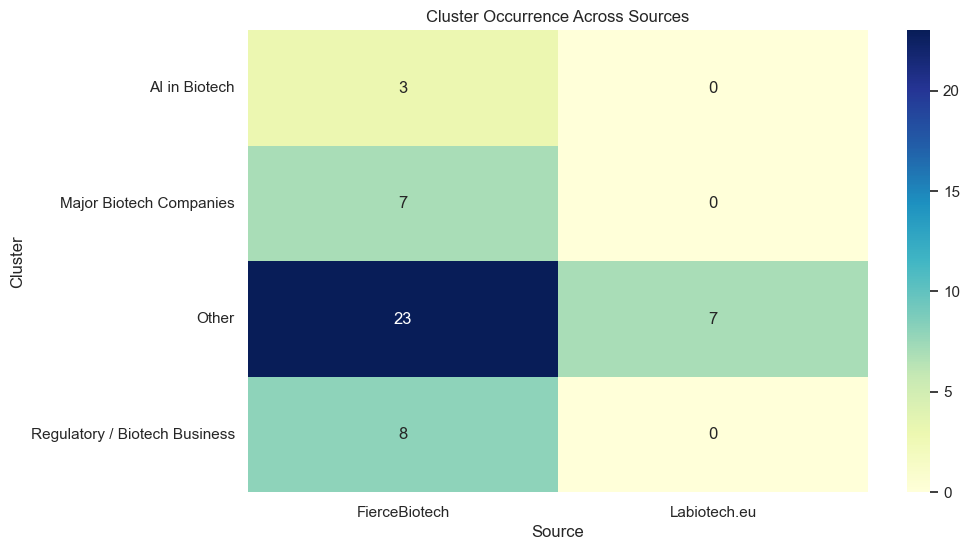

In [19]:
import seaborn as sns

# Explode clusters
df_heat = df.explode('clusters')

# Pivot table: counts of cluster per source
heat_data = df_heat.pivot_table(index='clusters', columns='source', aggfunc='size', fill_value=0)

plt.figure(figsize=(10,6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Cluster Occurrence Across Sources")
plt.xlabel("Source")
plt.ylabel("Cluster")
plt.show()
